# Cuaderno 02: Entrenamiento de la Vía Auditiva (Fonema -> Clasificación)

**Objetivo:** Entrenar un modelo que pueda identificar un fonema a partir de su secuencia completa de características de audio.

**Flujo de Trabajo:**
1.  **Instalación de Librerías**: Instalar `transformers`, `torch`, `torchaudio` y `librosa`.
2.  **Configuración**: Definir rutas y el modelo `wav2vec2` a utilizar.
3.  **Carga de Datos**: Cargar los archivos `.wav` de un idioma.
4.  **Extracción de Embeddings**: Procesar cada audio con `wav2vec2` para extraer la **secuencia completa** de embeddings.
5.  **Preparación del Dataset**: Crear `DataLoaders` que manejen secuencias de longitud variable mediante **padding**.
6.  **Definición y Entrenamiento del Modelo**: Construir y entrenar una **CNN 1D con Global Pooling** para clasificar las secuencias.
7.  **Evaluación y Guardado**: Generar una matriz de confusión, graficar métricas y guardar el modelo final.

## Paso 1: Instalación de Librerías

Instalamos las librerías de `transformers` de Hugging Face (para `wav2vec2`), `pytorch` (para la red neuronal), y `librosa` (una potente herramienta para el análisis de audio).

In [1]:
%pip install transformers torch torchaudio librosa scikit-learn seaborn protobuf --quiet
%gui qt

Note: you may need to restart the kernel to use updated packages.


## Paso 2: Configuración y Rutas

Importamos las librerías necesarias y definimos las rutas a los datos que generamos en el cuaderno anterior. También especificamos el modelo `wav2vec2` que usaremos. `xlsr-53` es un modelo multilingüe excelente.

In [2]:
import torch
import torchaudio
import librosa
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

# --- Parámetros Globales ---
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "cnn1d_comparative"
WAV2VEC2_MODEL_NAME = "facebook/wav2vec2-large-xlsr-53"
TARGET_SAMPLE_RATE = 16000
EPOCHS = 400
BATCH_SIZE = 8
LEARNING_RATE = 0.001

# --- Rutas ---
project_root = Path.cwd().parent
model_dir = project_root / "results/trained_models"
figure_dir = project_root / "results/figures"
results_dir = project_root / "results/tables"
model_dir.mkdir(parents=True, exist_ok=True)
figure_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Diccionario para almacenar todos los resultados
results = {}

## Paso 1: Definición del modelo, Bucle Principal de Procesamiento y Entrenamiento

Para la tarea de clasificar los fonemas a partir de sus embeddings, utilizaremos una **Red Neuronal Convolucional 1D (CNN 1D)**.

### Justificación Teórica 🧠

Los embeddings generados por `wav2vec2` no son vectores aislados, sino **secuencias temporales** que capturan cómo evoluciona un sonido a lo largo del tiempo. Una CNN 1D es una arquitectura ideal para este tipo de datos por las siguientes razones:

1.  **Detección de Patrones Locales**: Las capas convolucionales actúan como "detectores de características" que se deslizan a lo largo de la secuencia temporal. Pueden aprender a identificar patrones cortos y locales que son característicos de un fonema, como el inicio explosivo de una `/p/` o la vibración sostenida de una `/r/`.
2.  **Invariancia a la Posición**: Un patrón fonético relevante (como una transición de formantes) será detectado por la red sin importar en qué punto exacto de la secuencia ocurra.
3.  **Jerarquía de Características**: Al apilar capas convolucionales, el modelo aprende a combinar patrones simples en características más complejas y abstractas, lo que le permite construir una representación robusta del fonema.

### Flujo de Información del Modelo

El flujo de datos a través de nuestra `PhonemeCNN` es el siguiente:

**Entrada**: Una secuencia de embeddings de longitud variable `(Batch, Longitud_Secuencia, Features=1024)`.

1.  **Transposición**: La entrada se transpone a `(Batch, Features, Longitud_Secuencia)` para ser compatible con las capas `Conv1d` de PyTorch.
2.  **Bloque Convolucional 1**:
    * `Conv1d`: Aplica 128 filtros para detectar patrones temporales básicos.
    * `BatchNorm1d`: Normaliza las activaciones para estabilizar y acelerar el aprendizaje.
    * `ReLU`: Introduce no-linealidad.
3.  **Bloque Convolucional 2**:
    * `Conv1d`: Aplica 256 filtros sobre las características del bloque anterior, aprendiendo patrones más complejos.
    * `BatchNorm1d` y `ReLU`: Se repiten para la segunda capa.
4.  **`GlobalAveragePooling1d`**: Esta capa es clave. Promedia las salidas a lo largo de toda la dimensión temporal. Su función es doble:
    * **Maneja longitudes variables**: Produce una salida de tamaño fijo (`256 features`) sin importar la longitud de la secuencia de entrada.
    * **Agrega información**: Resume las características detectadas a lo largo de todo el fonema en un único vector representativo.
5.  **Capa de Clasificación (`Linear`)**:
    * Toma el vector de 256 características y lo proyecta al número de clases (fonemas) que queremos predecir.
6.  **Salida (Logits)**: El modelo produce un vector de "puntuaciones" (logits) para cada fonema. La función de pérdida `CrossEntropyLoss` aplicará internamente una operación **Softmax** sobre estos logits para convertirlos en probabilidades y calcular el error de clasificación.

In [3]:
def load_audio_data(directory, sample_rate):
    """Carga todos los archivos .wav de un directorio."""
    audio_data = []
    filepaths = sorted(list(directory.glob("*.wav")))
    
    for path in filepaths:
        try:
            waveform, sr = librosa.load(path, sr=sample_rate)
            label = path.stem
            audio_data.append({
                "path": path,
                "waveform": waveform,
                "label": label
            })
        except Exception as e:
            print(f"Error cargando el archivo {path}: {e}")
            
    return audio_data

for lang in LANGUAGES:
    print(f"\n{'='*20} PROCESANDO IDIOMA: {lang.upper()} {'='*20}")
    
    # --- 1. Carga de Datos ---
    audio_dir = project_root / f"data/02_processed/phoneme_audio/{lang}"
    embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    embedding_dir.mkdir(parents=True, exist_ok=True)

    phoneme_data = load_audio_data(audio_dir, TARGET_SAMPLE_RATE)
    print(f"Se cargaron {len(phoneme_data)} archivos de audio para '{lang}'.")

    # --- 2. Extracción de Embeddings (si no existen) ---
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(WAV2VEC2_MODEL_NAME)
    model_wav2vec = Wav2Vec2Model.from_pretrained(WAV2VEC2_MODEL_NAME)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_wav2vec.to(device)
    
    for item in phoneme_data:
        embedding_path = embedding_dir / f"{item['label']}.npy"
        if not embedding_path.exists():
            inputs = feature_extractor(item['waveform'], sampling_rate=TARGET_SAMPLE_RATE, return_tensors="pt", padding=True).input_values.to(device)
            with torch.no_grad():
                outputs = model_wav2vec(inputs)
            sequence_embedding = outputs.last_hidden_state.squeeze(0).cpu().numpy()
            np.save(embedding_path, sequence_embedding)
    
    # --- 3. Preparación del Dataset ---
    labels = [item['label'] for item in phoneme_data]
    embedding_sequences = [torch.tensor(np.load(embedding_dir / f"{label}.npy"), dtype=torch.float32) for label in labels]
    label_to_int = {label: i for i, label in enumerate(labels)}
    int_to_label = {i: label for label, i in label_to_int.items()}
    num_classes = len(labels)
    labels_tensor = torch.tensor([label_to_int[label] for label in labels], dtype=torch.long)

    class PhonemeSequenceDataset(Dataset):
        def __init__(self, embeddings, labels): self.embeddings, self.labels = embeddings, labels
        def __len__(self): return len(self.labels)
        def __getitem__(self, idx): return self.embeddings[idx], self.labels[idx]

    full_dataset = PhonemeSequenceDataset(embedding_sequences, labels_tensor)
    
    def collate_fn(batch):
        embeddings = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        labels = torch.stack(labels)
        padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
        return padded_embeddings, labels

    data_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

    # --- 4. Entrenamiento del Modelo ---
    class PhonemeCNN(nn.Module):
        def __init__(self, input_size, num_classes):
            super(PhonemeCNN, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm1d(128)
            self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm1d(256)
            self.fc = nn.Linear(256, num_classes)
        def forward(self, x):
            x = x.transpose(1, 2); x = F.relu(self.bn1(self.conv1(x))); x = F.relu(self.bn2(self.conv2(x)))
            x = F.adaptive_avg_pool1d(x, 1).squeeze(-1); x = self.fc(x); return x

    input_size = embedding_sequences[0].shape[1]
    model_cnn = PhonemeCNN(input_size=input_size, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_cnn.parameters(), lr=LEARNING_RATE)
    history = {'train_loss': [], 'train_accuracy': []}

    print(f"Entrenando modelo para '{lang}'...")
    for epoch in range(EPOCHS):
        model_cnn.train()
        running_loss, correct_preds, total_samples = 0.0, 0, 0
        for batch_embeddings, batch_labels in data_loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
            optimizer.zero_grad(); outputs = model_cnn(batch_embeddings); loss = criterion(outputs, batch_labels)
            loss.backward(); optimizer.step(); running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1); total_samples += batch_labels.size(0)
            correct_preds += (predicted == batch_labels).sum().item()
        history['train_loss'].append(running_loss / len(data_loader))
        history['train_accuracy'].append(100 * correct_preds / total_samples)
    
    # --- 5. Evaluación ---
    model_cnn.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for batch_embeddings, batch_labels in data_loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
            outputs = model_cnn(batch_embeddings); _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(batch_labels.cpu().numpy()); all_preds.extend(predicted.cpu().numpy())

    # --- 6. Guardar Tablas de Resultados ---
    # Guardar la historia del entrenamiento
    history_df = pd.DataFrame(history)
    history_path = results_dir / f"{lang}_auditory_{MODEL_ARCHITECTURE}_training_history.csv"
    history_df.to_csv(history_path, index_label="epoch")
    print(f"Historial de entrenamiento para '{lang}' guardado.")

    # Guardar el informe de clasificación
    class_names = [int_to_label[i] for i in range(num_classes)]
    report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_path = results_dir / f"{lang}_auditory_{MODEL_ARCHITECTURE}_classification_report.csv"
    report_df.to_csv(report_path)
    print(f"Informe de clasificación para '{lang}' guardado.")

    # --- Guardar todo en el diccionario de resultados ---
    results[lang] = {
        'labels': labels,
        'embedding_sequences': embedding_sequences,
        'label_to_int': label_to_int,
        'int_to_label': int_to_label,
        'history': history,
        'true_labels': all_labels,
        'predicted_labels': all_preds,
        'model': model_cnn
    }
    
    # Guardar el modelo en disco
    model_path = model_dir / f"{lang}_auditory_{MODEL_ARCHITECTURE}.pth"
    torch.save(model_cnn.state_dict(), model_path)
    print(f"Modelo para '{lang}' entrenado y guardado.")

print(f"\n{'='*20} PROCESO COMPLETADO PARA TODOS LOS IDIOMAS {'='*20}")


==================== PROCESANDO IDIOMA: ES ====================
Se cargaron 27 archivos de audio para 'es'.


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

  2025-08-29T15:53:06.592132Z  WARN  Reqwest(reqwest::Error { kind: Request, url: "https://cas-server.xethub.hf.co/reconstruction/152ae5580ef8f8b1c8326fad7a8690240cd3ec7c81d730313f1d188964d403f5", source: hyper_util::client::legacy::Error(Connect, ConnectError("dns error", Custom { kind: Uncategorized, error: "failed to lookup address information: Temporary failure in name resolution" })) }). Retrying...
    at /home/runner/work/xet-core/xet-core/cas_client/src/http_client.rs:226

  2025-08-29T15:53:06.592258Z  WARN  Retry attempt #0. Sleeping 543.393106ms before the next attempt
    at /root/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/reqwest-retry-0.7.0/src/middleware.rs:171

  2025-08-29T15:53:17.148924Z  WARN  Reqwest(reqwest::Error { kind: Request, url: "https://cas-server.xethub.hf.co/reconstruction/152ae5580ef8f8b1c8326fad7a8690240cd3ec7c81d730313f1d188964d403f5", source: hyper_util::client::legacy::Error(Connect, ConnectError("dns error", Custom { kind: Uncategorized, 

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Historial de entrenamiento para 'es' guardado.
Informe de clasificación para 'es' guardado.
Modelo para 'es' entrenado y guardado.

==================== PROCESANDO IDIOMA: EN ====================
Se cargaron 33 archivos de audio para 'en'.
Entrenando modelo para 'en'...
Historial de entrenamiento para 'en' guardado.
Informe de clasificación para 'en' guardado.
Modelo para 'en' entrenado y guardado.

==================== PROCESO COMPLETADO PARA TODOS LOS IDIOMAS ====================


## Paso 2: Visualizaciones Comparativas

Ahora que todos los resultados están en el diccionario `results`, podemos crear gráficos que comparen directamente el rendimiento y la estructura de los embeddings entre español e inglés.

### 2.1 Curvas de Aprendizaje Comparativas

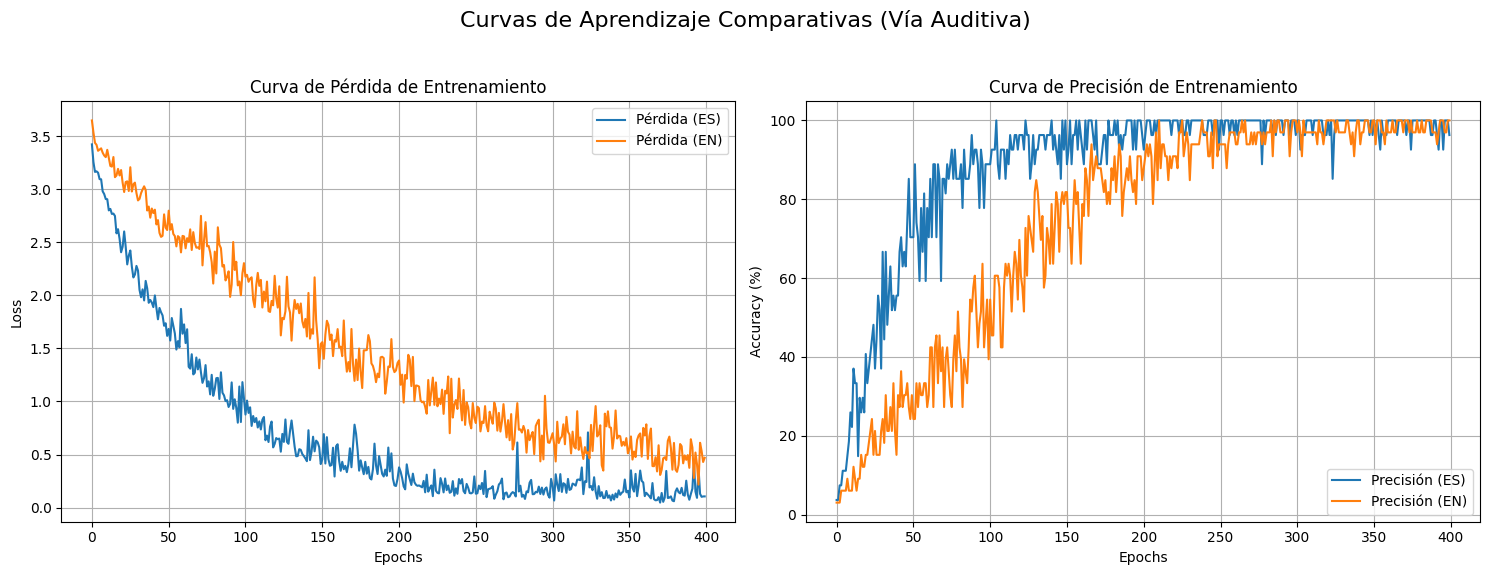

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de Pérdida
for lang in LANGUAGES:
    ax1.plot(results[lang]['history']['train_loss'], label=f'Pérdida ({lang.upper()})')
ax1.set_title('Curva de Pérdida de Entrenamiento')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

# Gráfico de Precisión
for lang in LANGUAGES:
    ax2.plot(results[lang]['history']['train_accuracy'], label=f'Precisión ({lang.upper()})')
ax2.set_title('Curva de Precisión de Entrenamiento')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy (%)'); ax2.legend(); ax2.grid(True)

fig.suptitle('Curvas de Aprendizaje Comparativas (Vía Auditiva)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(figure_dir / f"comparative_auditory_{MODEL_ARCHITECTURE}_learning_curves.png")
plt.show()

### 2.2 Matrices de Confusión (Lado a Lado)

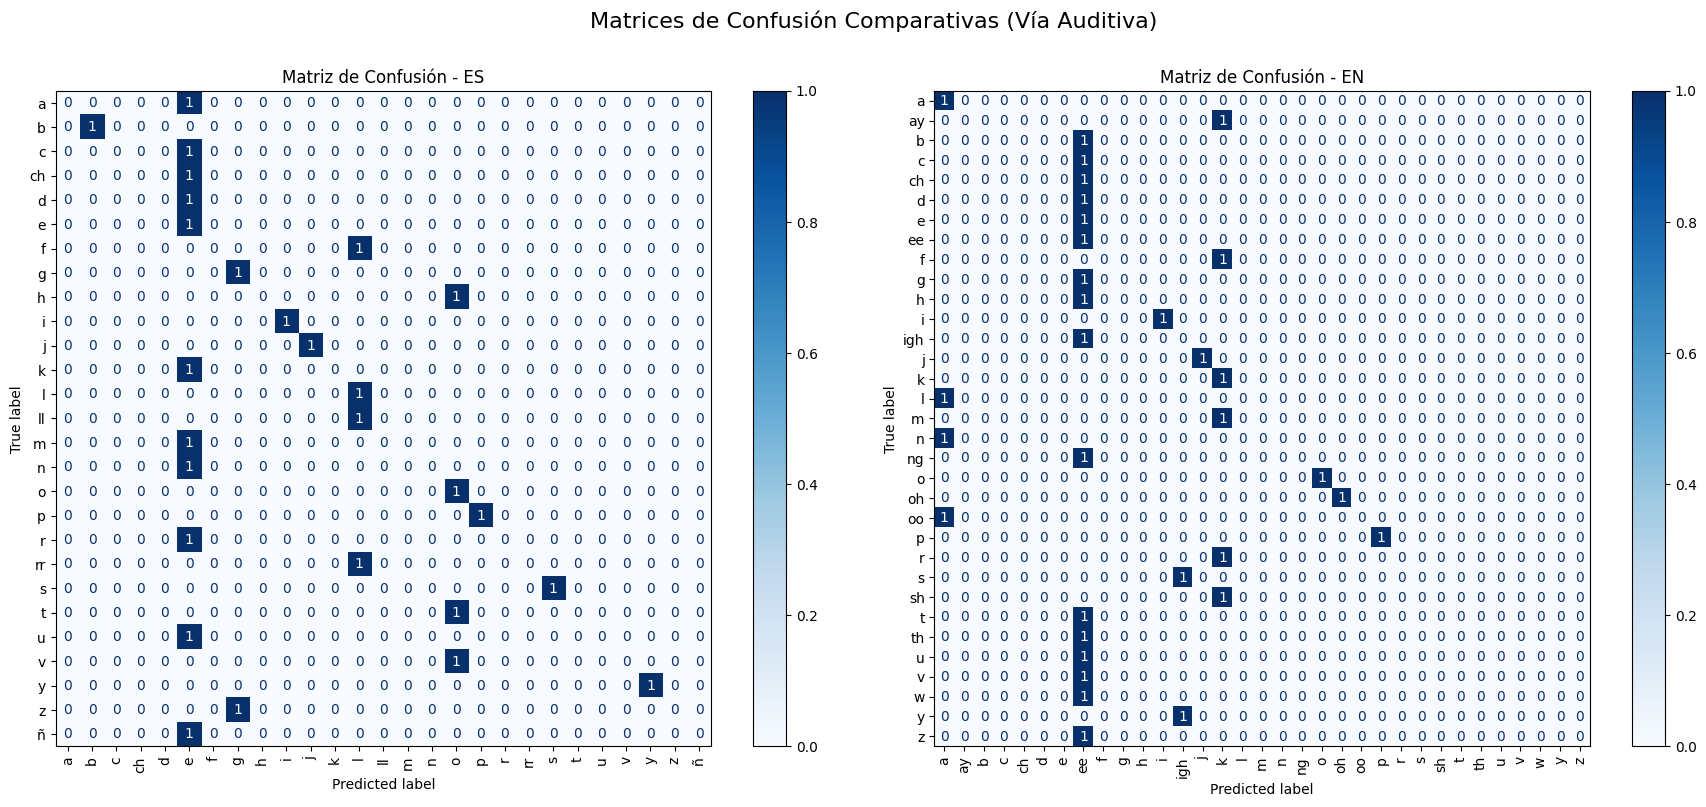

In [5]:
fig, axes = plt.subplots(1, len(LANGUAGES), figsize=(18, 8))

for i, lang in enumerate(LANGUAGES):
    ax = axes[i]
    class_names = list(results[lang]['label_to_int'].keys())
    cm = confusion_matrix(results[lang]['true_labels'], results[lang]['predicted_labels'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    ax.set_title(f'Matriz de Confusión - {lang.upper()}')

fig.suptitle('Matrices de Confusión Comparativas (Vía Auditiva)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(figure_dir / f"comparative_auditory_{MODEL_ARCHITECTURE}_confusion_matrix.png")
plt.show()

### 2.3 Análisis de Embeddings t-SNE (Fusionado)

Para este gráfico, combinamos los embeddings de ambos idiomas en un solo análisis t-SNE. Usamos el color (`hue`) para diferenciar entre español e inglés, permitiéndonos ver si los fonemas de cada idioma forman clusters separados o si se mezclan.

Calculando proyección t-SNE para ambos idiomas...


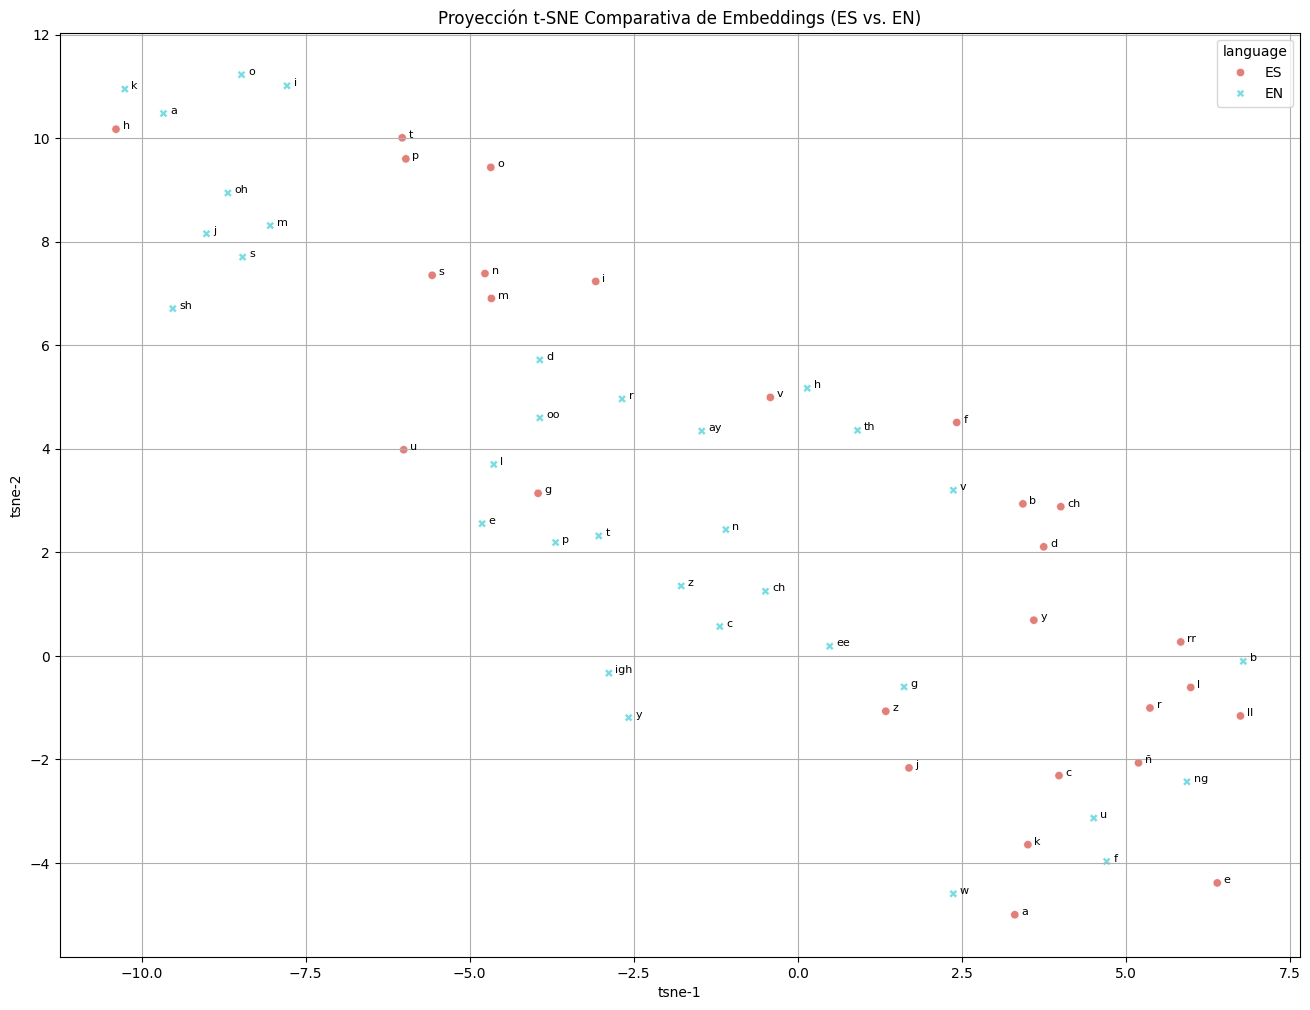

In [6]:
# --- Preparar datos para el gráfico fusionado ---
all_embeddings_avg = []
all_labels = []
all_langs = []

for lang in LANGUAGES:
    # Usamos el promedio de los embeddings para la visualización
    lang_embeddings_avg = [seq.mean(dim=0).numpy() for seq in results[lang]['embedding_sequences']]
    all_embeddings_avg.extend(lang_embeddings_avg)
    all_labels.extend(results[lang]['labels'])
    all_langs.extend([lang.upper()] * len(results[lang]['labels']))

embedding_matrix_combined = np.array(all_embeddings_avg)

# --- Calcular t-SNE ---
print("Calculando proyección t-SNE para ambos idiomas...")
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(embedding_matrix_combined)

# --- Crear DataFrame para graficar ---
tsne_df = pd.DataFrame({
    'tsne-1': embeddings_2d[:, 0],
    'tsne-2': embeddings_2d[:, 1],
    'phoneme': all_labels,
    'language': all_langs
})

# --- Graficar ---
plt.figure(figsize=(16, 12))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="language",
    style="language",
    palette=sns.color_palette("hls", len(LANGUAGES)),
    data=tsne_df,
    legend="full",
    alpha=0.8
)

# Añadir anotaciones
for i, row in tsne_df.iterrows():
    plt.text(row['tsne-1']+0.1, row['tsne-2'], row['phoneme'], fontsize=8)

plt.title('Proyección t-SNE Comparativa de Embeddings (ES vs. EN)')
plt.grid(True)
plt.savefig(figure_dir / "comparative_auditory_tsne_plot.png")
plt.show()

### 2.4 Heatmaps de Logits Comparativos

Mientras que la matriz de confusión nos muestra las decisiones finales (aciertos y errores), un heatmap de los **logits** nos permite ver la "fuerza de la evidencia" que el modelo considera para cada clase.

-   Una **diagonal brillante** indica que el modelo asigna una puntuación muy alta al fonema correcto.
-   **Puntos brillantes fuera de la diagonal** revelan qué fonemas son fonéticamente similares para el modelo, incluso si no fueron la predicción final.

Aquí podemos esperar ver una diagonal más "fuerte" y "limpia" para el español, y más "confusión" (puntuaciones altas fuera de la diagonal) para el inglés, lo que apoyaría la hipótesis de la transparencia grafema-fonema.

--- Generando heatmap de logits para: ES ---
Forma de la matriz de logits para ES: (27, 27)
--- Generando heatmap de logits para: EN ---
Forma de la matriz de logits para EN: (33, 33)


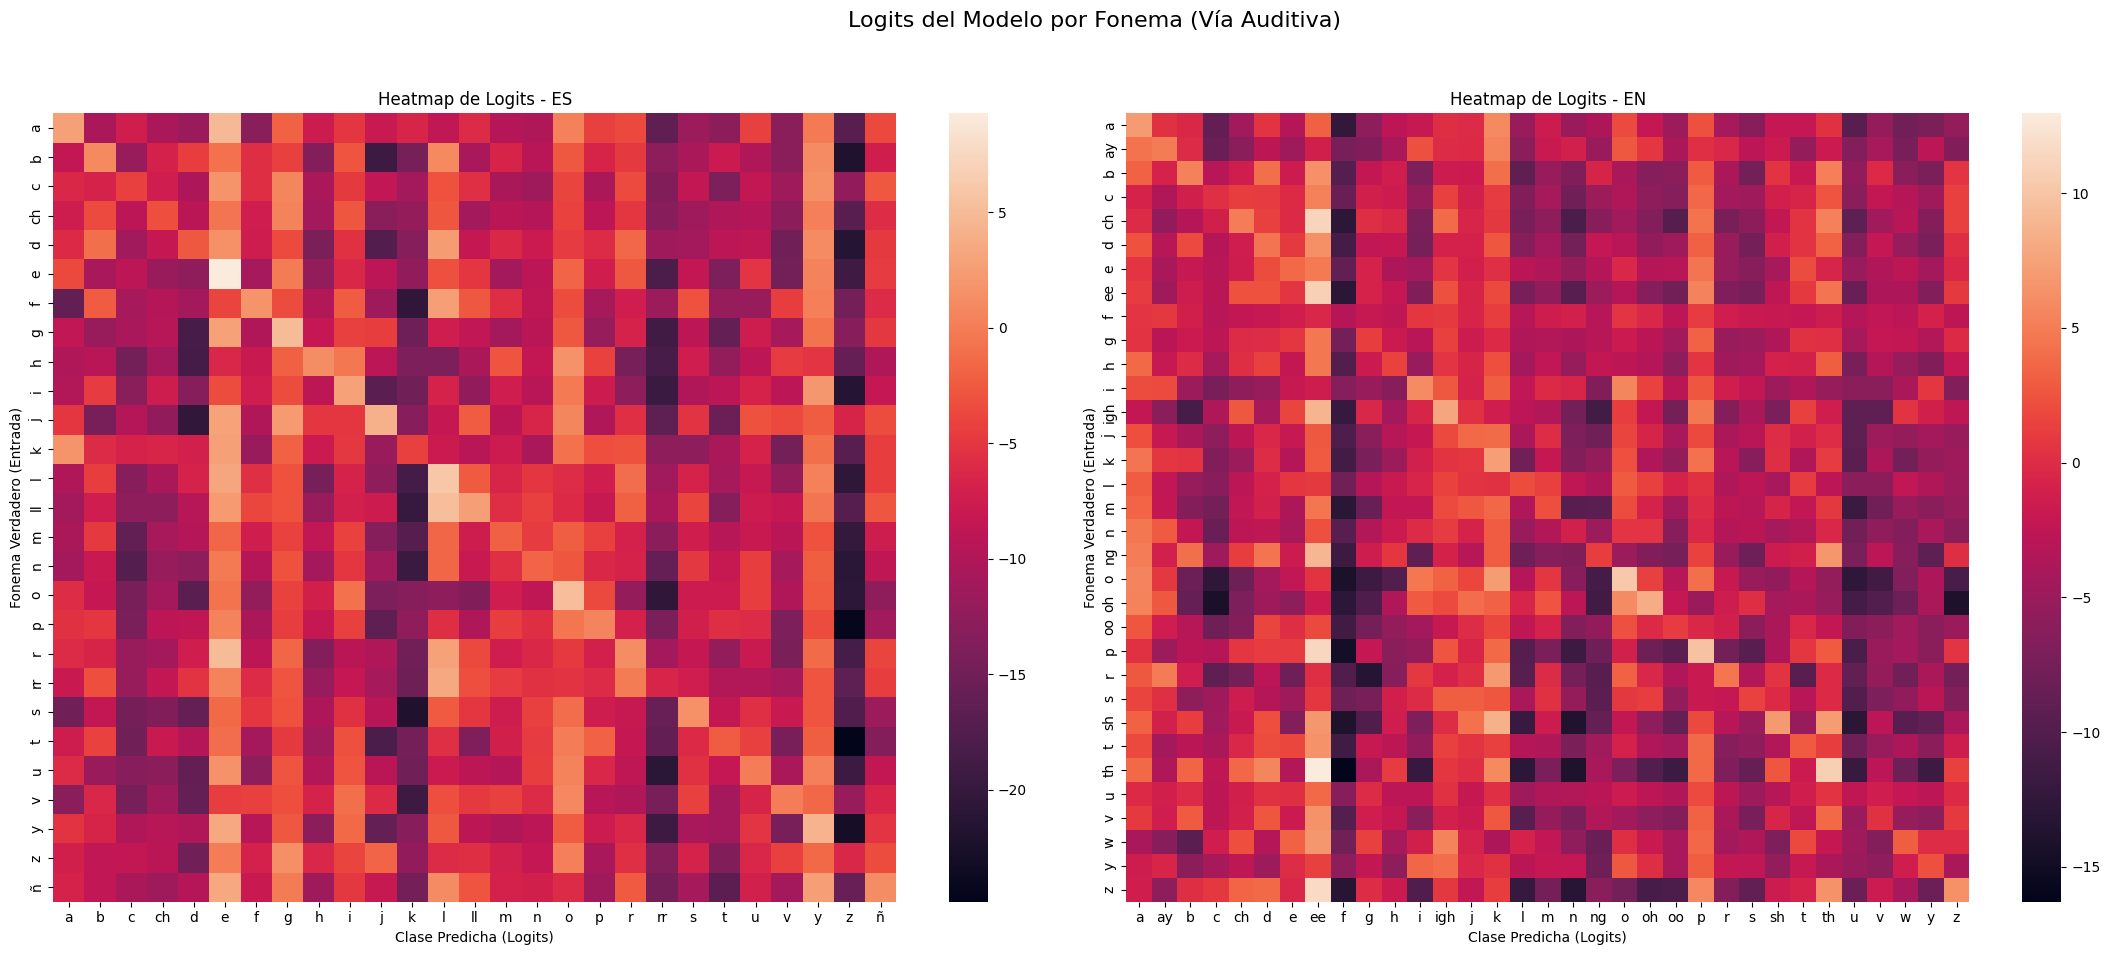

In [7]:
# --- Preparar datos para los heatmaps de logits ---
fig, axes = plt.subplots(1, len(LANGUAGES), figsize=(22, 10), sharey=False) # sharey=False es importante si los idiomas tienen distinto # de fonemas

# Asegurarse de que axes sea un array para poder indexarlo
if len(LANGUAGES) == 1:
    axes = [axes]

for i, lang in enumerate(LANGUAGES):
    ax = axes[i]
    
    print(f"--- Generando heatmap de logits para: {lang.upper()} ---")
    
    # Extraer los datos específicos para este idioma del diccionario 'results'
    model_lang = results[lang]['model']
    embedding_sequences_lang = results[lang]['embedding_sequences']
    labels_lang = results[lang]['labels']
    
    # Ordenar los embeddings y etiquetas para que los ejes del gráfico sean consistentes
    sorted_indices = np.argsort(labels_lang)
    sorted_labels = np.array(labels_lang)[sorted_indices]
    sorted_embeddings = [embedding_sequences_lang[j] for j in sorted_indices]
    
    # Crear un DataLoader sin shuffle para procesar en el orden correcto
    # Usamos el Dataset y collate_fn definidos en celdas anteriores
    sorted_dataset = PhonemeSequenceDataset(sorted_embeddings, torch.tensor(sorted_indices, dtype=torch.long))
    sorted_loader = DataLoader(sorted_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    # Poner el modelo en modo de evaluación
    model_lang.eval()
    all_logits = []
    with torch.no_grad():
        for batch_embeddings, _ in sorted_loader:
            batch_embeddings = batch_embeddings.to(device)
            outputs = model_lang(batch_embeddings)
            all_logits.append(outputs.cpu().numpy())
    
    # Concatenar los logits de todos los lotes
    logits_matrix = np.vstack(all_logits)
    
    # Línea de diagnóstico: La matriz debe ser cuadrada (ej. 28x28)
    print(f"Forma de la matriz de logits para {lang.upper()}: {logits_matrix.shape}")
    
    # Crear el heatmap
    sns.heatmap(
        logits_matrix,
        xticklabels=sorted_labels,
        yticklabels=sorted_labels,
        ax=ax,
        cmap='rocket',
        annot=False
    )
    ax.set_title(f'Heatmap de Logits - {lang.upper()}')
    ax.set_xlabel('Clase Predicha (Logits)')
    ax.set_ylabel('Fonema Verdadero (Entrada)')

fig.suptitle('Logits del Modelo por Fonema (Vía Auditiva)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(figure_dir / f"comparative_auditory_{MODEL_ARCHITECTURE}_logits_heatmap.png")
plt.show()